# TMLE Example Notebook

This notebook demonstrates the issue of using uplift curves without knowing true treatment effect and how to solve it by using TMLE as a proxy of the true treatment effect.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import sys
import warnings
warnings.simplefilter("ignore", UserWarning)

from lightgbm import LGBMRegressor

In [6]:
import causalml

from causalml.dataset import synthetic_data
from causalml.inference.meta import BaseXRegressor, TMLELearner
from causalml.metrics.visualize import *
from causalml.propensity import calibrate

print(causalml.__version__)

0.7.0


In [7]:
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)
plt.style.use('fivethirtyeight')

## Generating Synthetic Data

In [8]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=1000000, p=10, sigma=5.)

In [9]:
X_train, X_test, y_train, y_test, e_train, e_test, treatment_train, treatment_test, tau_train, tau_test, b_train, b_test = train_test_split(X, y, e, treatment, tau, b, test_size=0.5, random_state=42)

## Calculating Individual Treatment Effect (ITE/CATE)

In [10]:
# X Learner
learner_x = BaseXRegressor(learner=LGBMRegressor())
learner_x.fit(X=X_train, treatment=treatment_train, y=y_train)
cate_x_test = learner_x.predict(X=X_test, p=e_test, treatment=treatment_test).flatten()

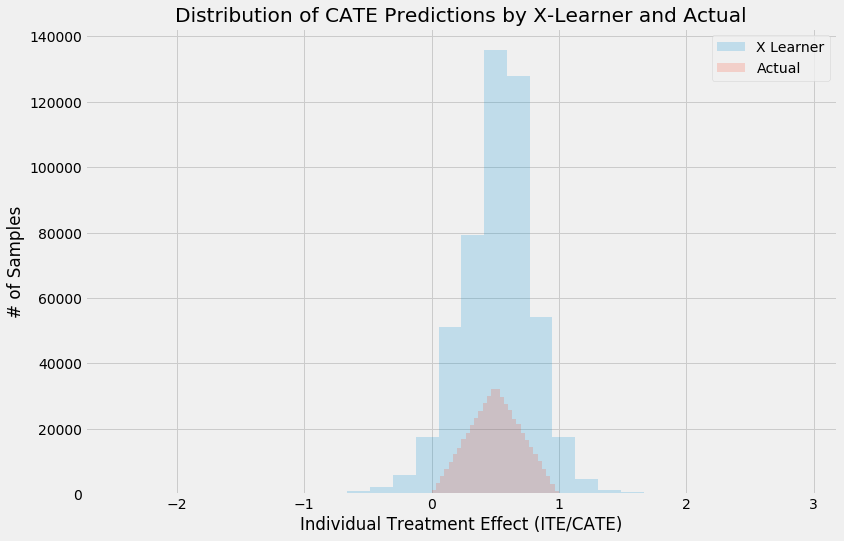

In [11]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_x_test, alpha=alpha, bins=bins, label='X Learner')
plt.hist(tau_test, alpha=alpha, bins=bins, label='Actual')

plt.title('Distribution of CATE Predictions by X-Learner and Actual')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

## Validating CATE without TMLE

In [12]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'tau': tau_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

### Uplift Curve With Ground Truth

If true treatment effect is known as in simulations, the uplift curve of a model uses the cumulative sum of the treatment effect sorted by model's CATE estimate.

In the figure below, the uplift curve of X-learner shows positive lift close to the optimal lift by the ground truth.

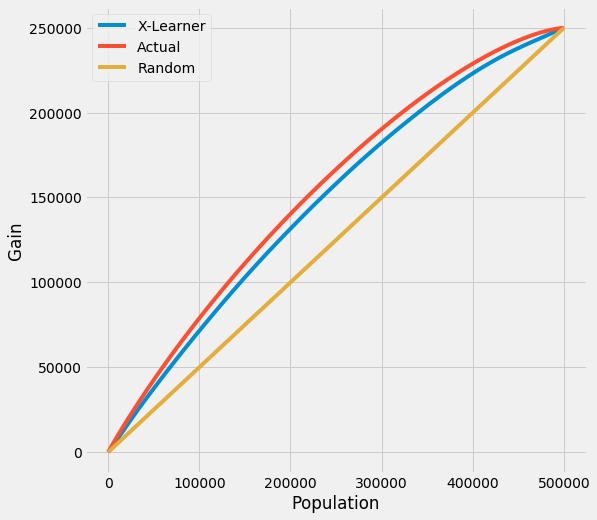

In [13]:
plot(df, outcome_col='y', treatment_col='w', treatment_effect_col='tau')

### Uplift Curve Without Ground Truth

If true treatment effect is unknown as in practice, the uplift curve of a model uses the cumulative mean difference of outcome in the treatment and control group sorted by model's CATE estimate.

In the figure below, the uplift curves of X-learner as well as the ground truth show no lift incorrectly.

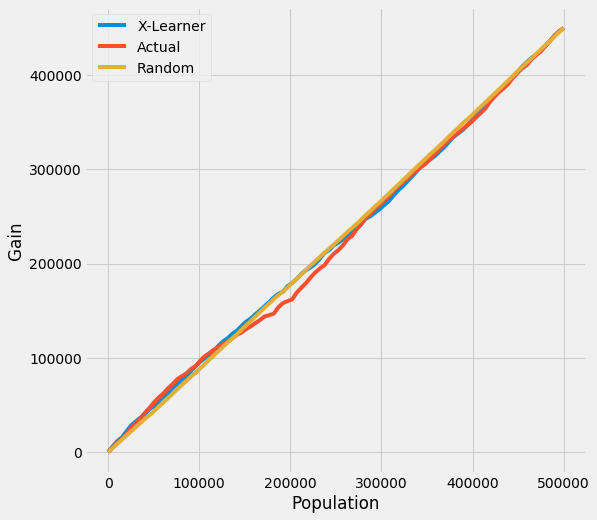

In [14]:
plot(df.drop('tau', axis=1), outcome_col='y', treatment_col='w')

## TMLE 

### Uplift Curve with TMLE as Ground Truth

In [19]:
n_fold = 5
kf = KFold(n_splits=n_fold)

In [15]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'p': e_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

In [16]:
inference_cols = []
for i in range(X_test.shape[1]):
    col = 'col_' + str(i)
    df[col] = X_test[:,i]
    inference_cols.append(col)

In [17]:
df.head()

,y,w,p,X-Learner,Actual,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
0,0.568636,0,0.856002,0.557387,0.576685,0.650892,0.502478,0.818679,0.353106,0.392549,0.716396,0.967487,0.594988,0.103970,0.590664
1,-0.566821,0,0.636789,0.718870,0.498000,0.666126,0.329874,0.096100,0.899631,0.025183,0.371497,0.665350,0.632375,0.874065,0.057529
2,3.810857,0,0.125503,0.338962,0.264017,0.091823,0.436211,0.066030,0.617377,0.076842,0.746436,0.400022,0.332349,0.097941,0.735413
3,8.127026,0,0.100000,0.270343,0.075412,0.076913,0.073910,0.124141,0.186304,0.558969,0.601961,0.355907,0.111462,0.847023,0.163163
4,-2.727135,0,0.167487,0.226385,0.276645,0.428194,0.125096,0.139052,0.006848,0.717605,0.589799,0.368744,0.607416,0.059442,0.190864


In [20]:
tmle_df = get_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                       n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

In [21]:
tmle_df

,X-Learner,Actual,Random
0.0,0.000000,0.000000,0.000000
0.2,0.145151,0.146628,0.096077
0.4,0.252563,0.255667,0.192154
0.6,0.352174,0.364541,0.288231
0.8,0.433351,0.446890,0.384308
1.0,0.480384,0.480384,0.480384


#### Uplift Curve wihtout CI

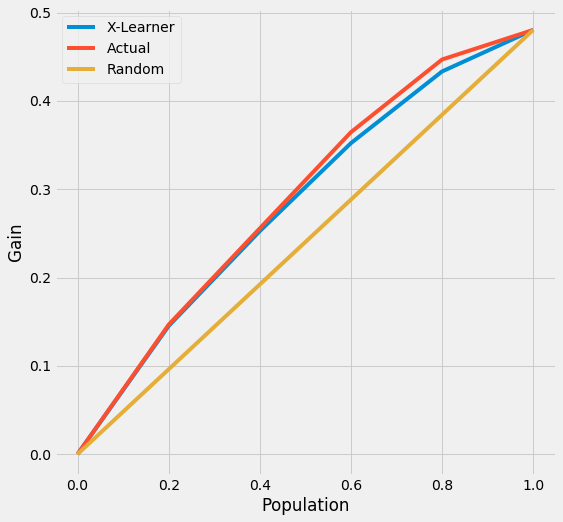

In [22]:
plot_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

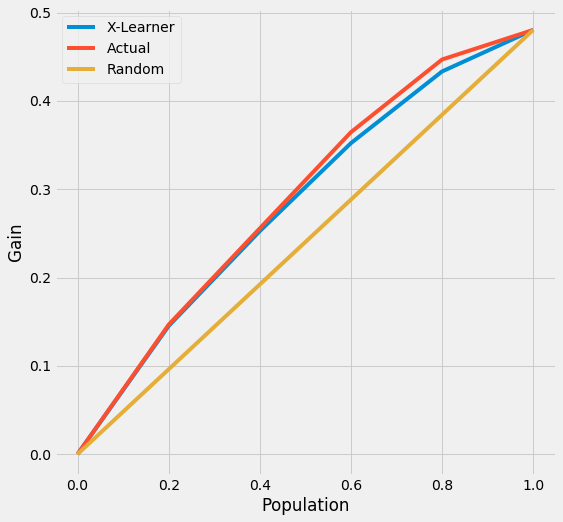

In [23]:
plot(df, kind='gain', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

#### AUUC Score

In [24]:
auuc_score_tmle(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

X-Learner    0.277270
Actual       0.282352
Random       0.240192
dtype: float64

#### Uplift Curve with CI

In [25]:
tmle_df = get_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                       n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

In [26]:
tmle_df

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB,Random
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.2,0.145151,0.146628,0.127016,0.127210,0.163285,0.166046,0.096077
0.4,0.252563,0.255667,0.216629,0.218323,0.288496,0.293011,0.192154
0.6,0.352174,0.364541,0.300866,0.313233,0.403483,0.415850,0.288231
0.8,0.433351,0.446890,0.366285,0.380624,0.500417,0.513157,0.384308
1.0,0.480384,0.480384,0.441999,0.441999,0.518770,0.518770,0.480384


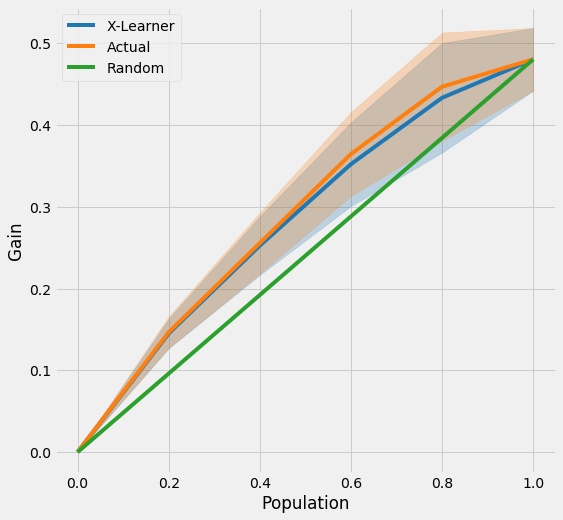

In [27]:
plot_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

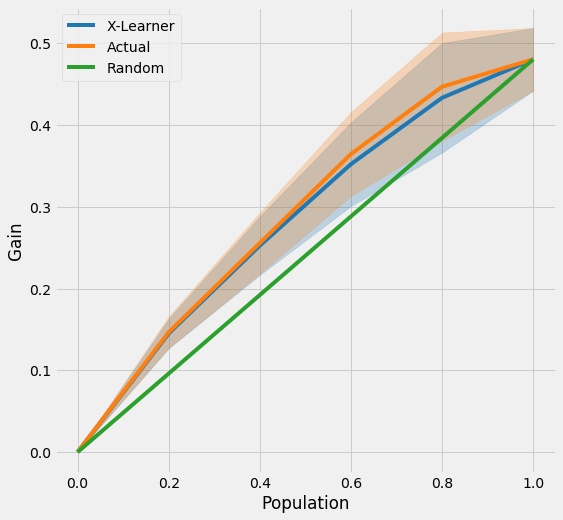

In [29]:
plot(df, kind='gain', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

### Qini Curve with TMLE as Ground Truth

#### Qini Curve without CI

In [30]:
qini = get_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                    n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

In [31]:
qini

,X-Learner,Actual,Random
0.0,0.000000,0.000000,0.000000
100000.0,53513.373815,59840.329296,24964.329463
200000.0,92693.576894,104578.508000,49928.658925
300000.0,121232.782373,132653.427128,74892.988388
400000.0,136045.083604,145388.277994,99857.317851
500000.0,124821.647313,124821.647313,124821.647313


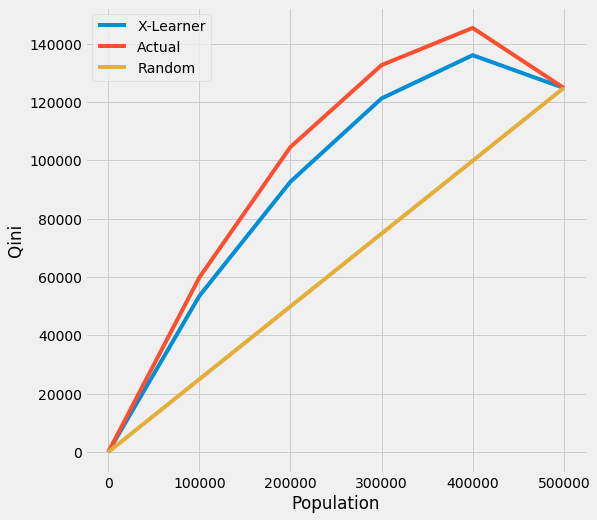

In [32]:
plot_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

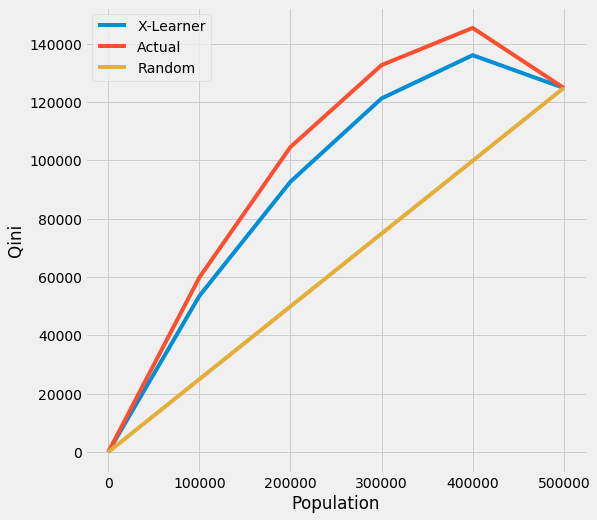

In [34]:
plot(df, kind='qini', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

#### Qini Score

In [35]:
qini_score_tmle(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

X-Learner    25640.253677
Actual       32136.207965
Random           0.000000
dtype: float64

#### Qini Curve with CI

In [36]:
qini = get_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                    n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

In [37]:
qini

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB,Random
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100000.0,53513.373815,59840.329296,46827.611036,51915.622165,60199.136594,67765.036427,24964.329463
200000.0,92693.576894,104578.508000,79515.426034,89298.783725,105871.727753,119858.232275,49928.658925
300000.0,121232.782373,132653.427128,103649.630931,113772.913012,138815.933816,151533.941243,74892.988388
400000.0,136045.083604,145388.277994,115586.643138,124194.530581,156503.524070,166582.025407,99857.317851
500000.0,124821.647313,124821.647313,124821.647313,124821.647313,124821.647313,124821.647313,124821.647313


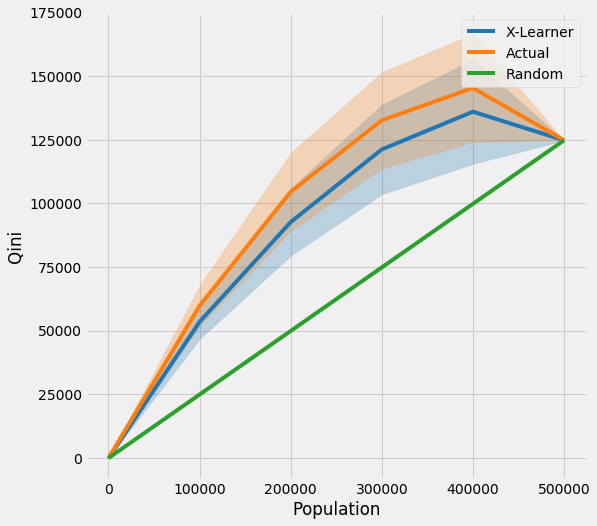

In [38]:
plot_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

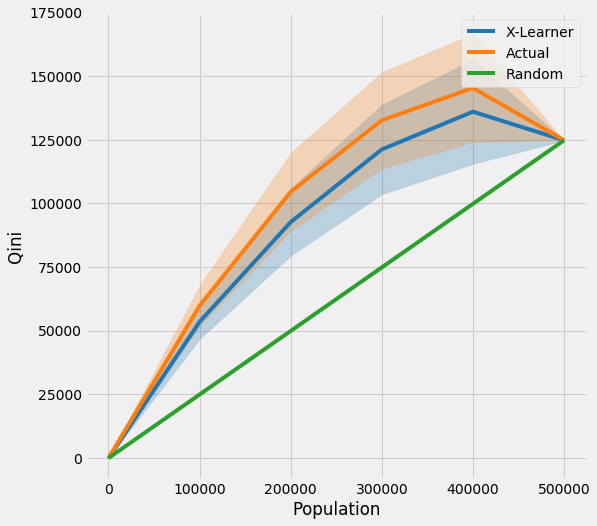

In [39]:
plot(df, kind='qini', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=True)